In [14]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from sympy import false

# Get the old and new data directories
list_of_commits = list(Path("../../logs/performance/regression").glob("*/"))

list_of_commits.sort(key=os.path.getmtime, reverse=True)
list_of_commits = list_of_commits[:2]
list_of_files_new = list(Path(list_of_commits[0] / "all").glob("*.csv"))
list_of_files_old = list(Path(list_of_commits[1] / "all").glob("*.csv"))
list_of_files_new_profiling = list(Path(list_of_commits[0] / "profiling").glob("*.csv"))
list_of_files_old_profiling = list(Path(list_of_commits[1] / "profiling").glob("*.csv"))

latest_file_new = max(list_of_files_new, key=os.path.getctime)
latest_file_old = max(list_of_files_old, key=os.path.getctime)

if false:
    # format: timestamp,category,test_name,query,scenario,fainder_mode,ncalls,tottime,percall_tottime,cumtime,percall_cumtime,function_info

    latest_file_new_profiling = max(list_of_files_new_profiling, key=os.path.getctime)
    latest_file_old_profiling = max(list_of_files_old_profiling, key=os.path.getctime)

    df_latest_new_profiling = pd.read_csv(latest_file_new_profiling)
    df_latest_old_profiling = pd.read_csv(latest_file_old_profiling)


# format: timestamp,category,test_name,query,scenario,execution_time,results_consistent,fainder_mode,num_results,ids,num_terms,id_str

df_latest_new = pd.read_csv(latest_file_new)
df_latest_old = pd.read_csv(latest_file_old)



# Filter df_latest_old to only include records with matching fainder_modes from df_latest_new
df_latest_old = df_latest_old[df_latest_old['fainder_mode'].isin(df_latest_new['fainder_mode'].unique())]

# assert num_results with the same test_name, query, scenario, fainder_mode
def compare_num_results(df1, df2):
    for i in range(len(df1)):
        test_name = df1.iloc[i]["test_name"]
        query = df1.iloc[i]["query"]
        scenario = df1.iloc[i]["scenario"]
        fainder_mode = df1.iloc[i]["fainder_mode"]
        num_results_1 = df1.iloc[i]["num_results"]
        num_results_2 = df2[
            (df2["test_name"] == test_name)
            & (df2["query"] == query)
            & (df2["scenario"] == scenario)
            & (df2["fainder_mode"] == fainder_mode)
        ]["num_results"].values[0]
        if num_results_1 != num_results_2:
            print(
                f"num_results mismatch: {test_name}, {query}, {scenario}, {fainder_mode}: {num_results_1} vs {num_results_2}"
            )
            return False
    return True

compare_num_results(df_latest_new, df_latest_old)

print(df_latest_new)

print(df_latest_old)


               timestamp                   category  \
0    2025-05-10 13:56:24       base_keyword_queries   
1    2025-05-10 13:56:24       base_keyword_queries   
2    2025-05-10 13:56:24       base_keyword_queries   
3    2025-05-10 13:56:24       base_keyword_queries   
4    2025-05-10 13:56:24       base_keyword_queries   
..                   ...                        ...   
875  2025-05-10 19:53:20  expected_form_not_queries   
876  2025-05-10 19:56:26  expected_form_not_queries   
877  2025-05-10 19:56:26  expected_form_not_queries   
878  2025-05-10 19:56:26  expected_form_not_queries   
879  2025-05-10 19:56:26  expected_form_not_queries   

                           test_name  \
0                   simple_keyword_1   
1                   simple_keyword_1   
2                   simple_keyword_1   
3                   simple_keyword_1   
4                   simple_keyword_1   
..                               ...   
875  mixed_combination_AND_1_0-1-2-3   
876  mixed_combinat

/tmp/ipykernel_15486/1457493789.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


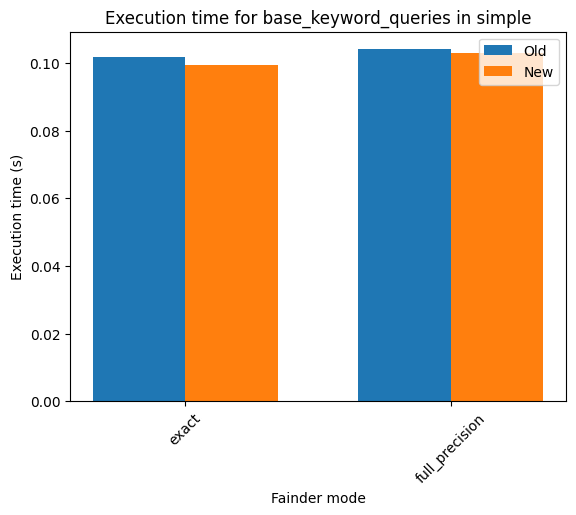

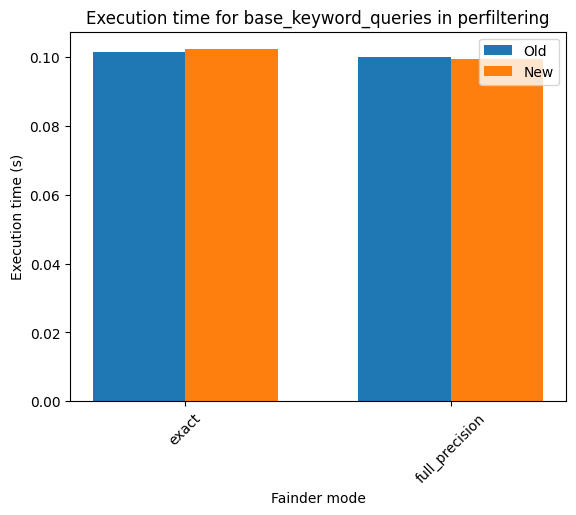

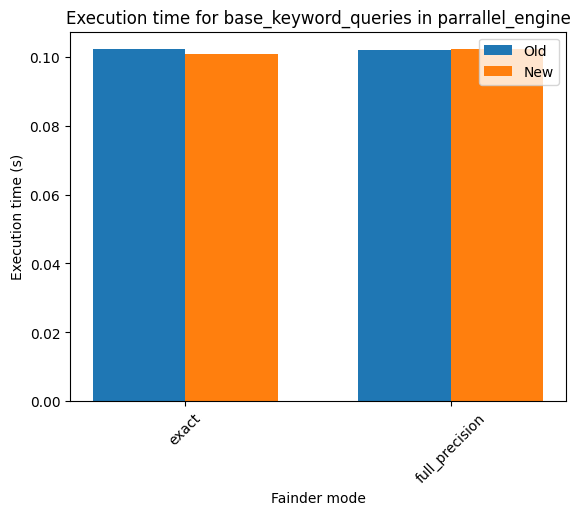

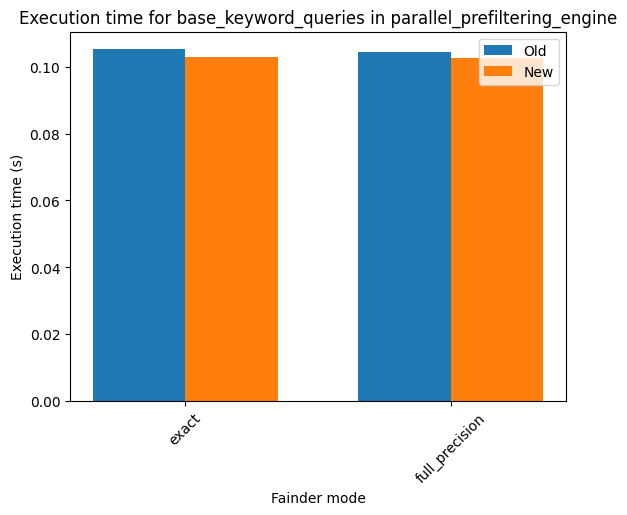

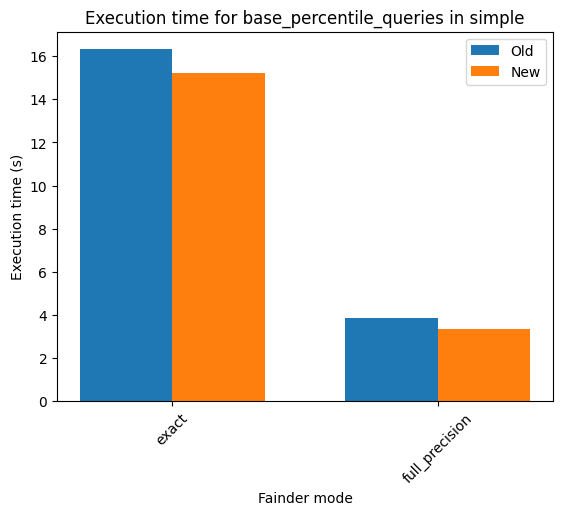

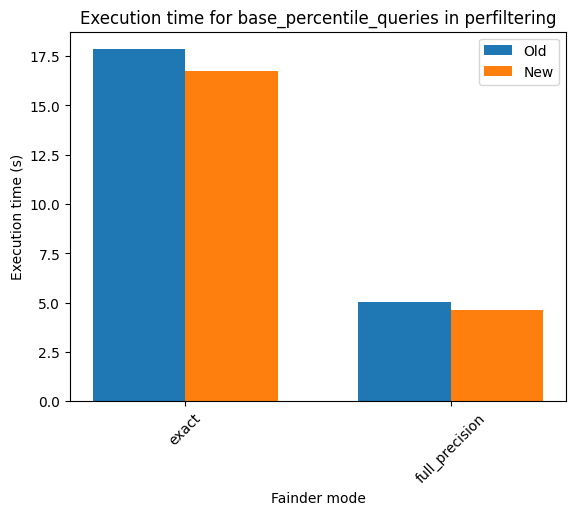

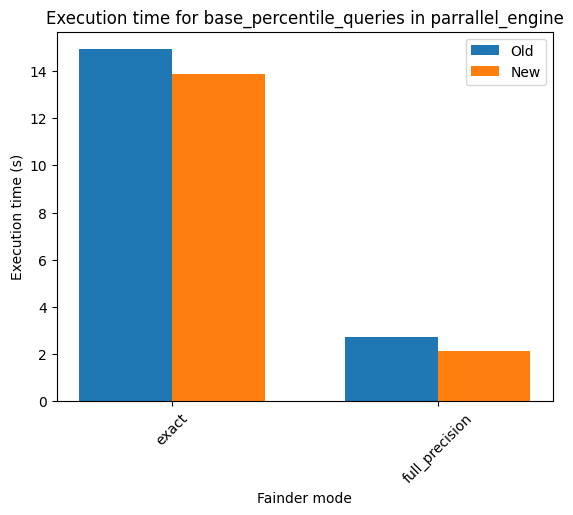

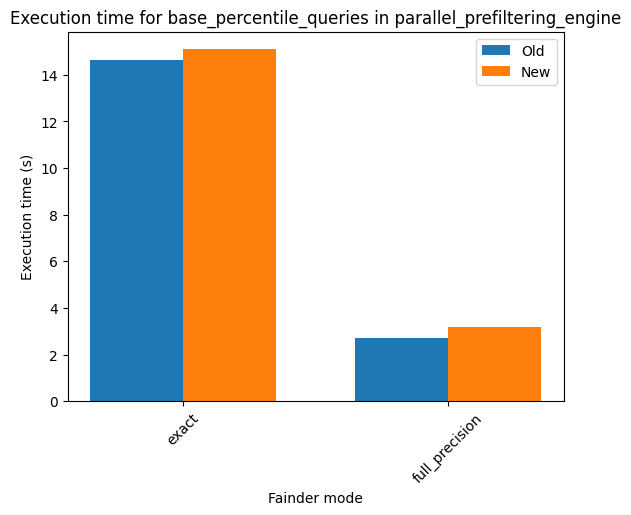

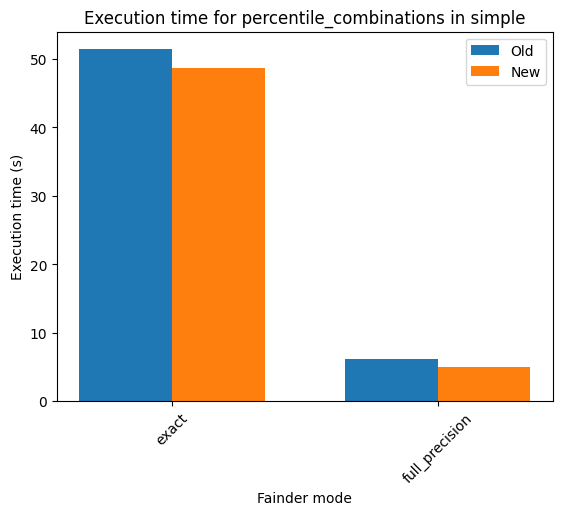

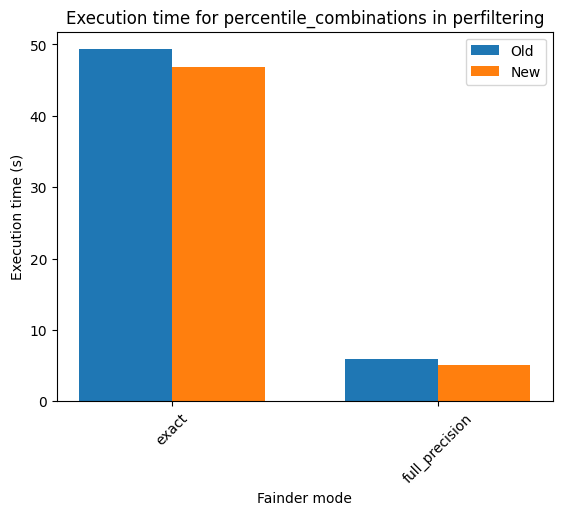

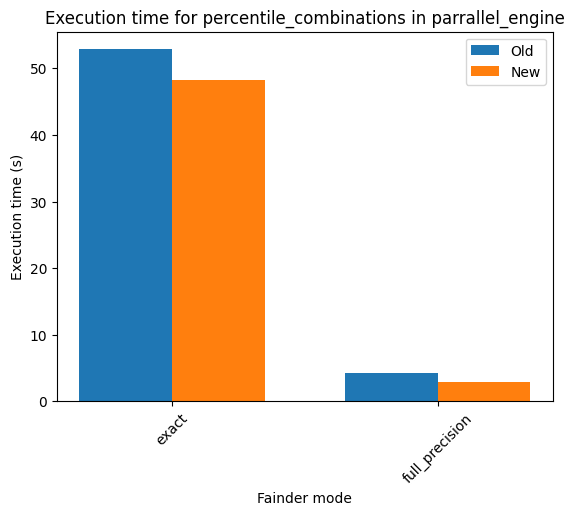

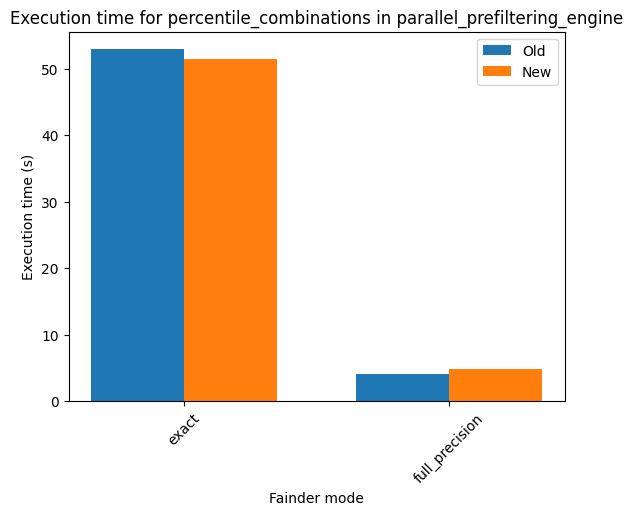

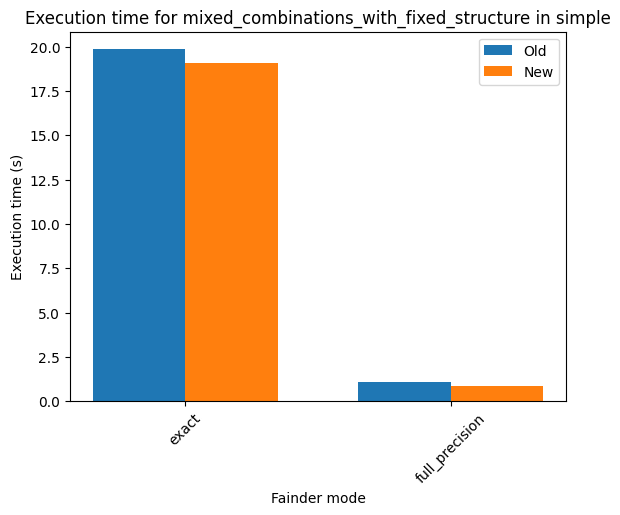

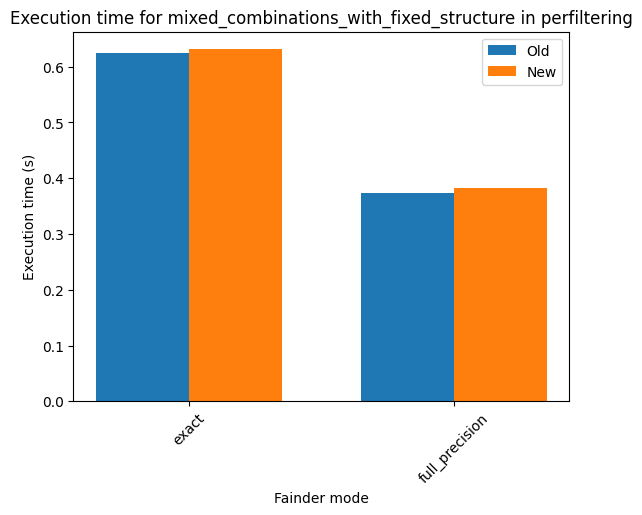

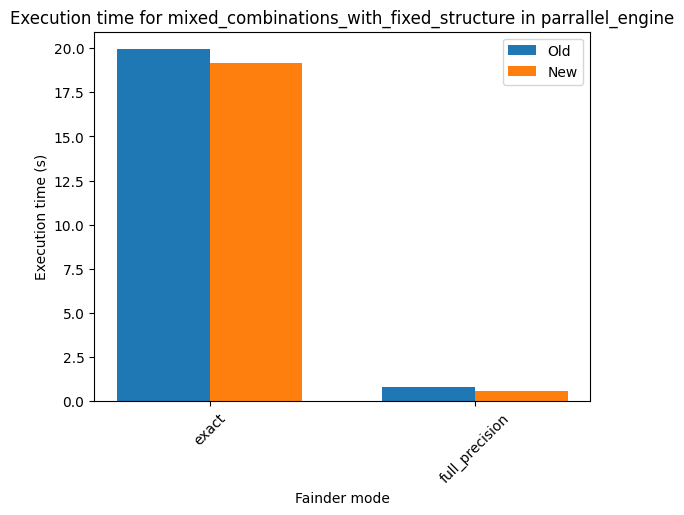

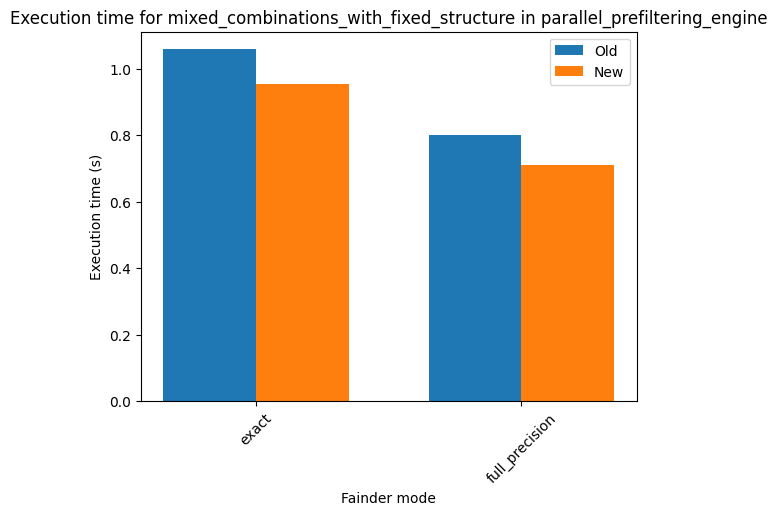

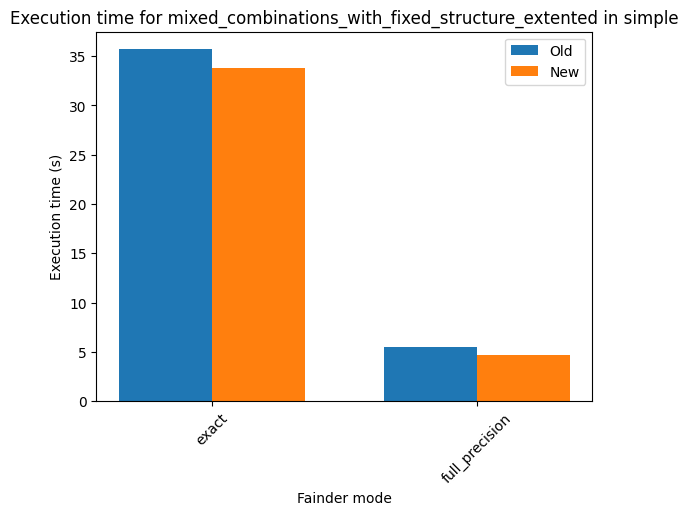

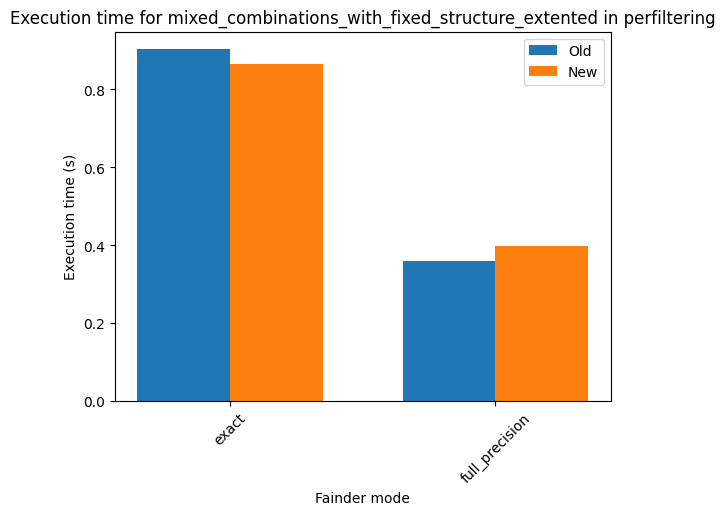

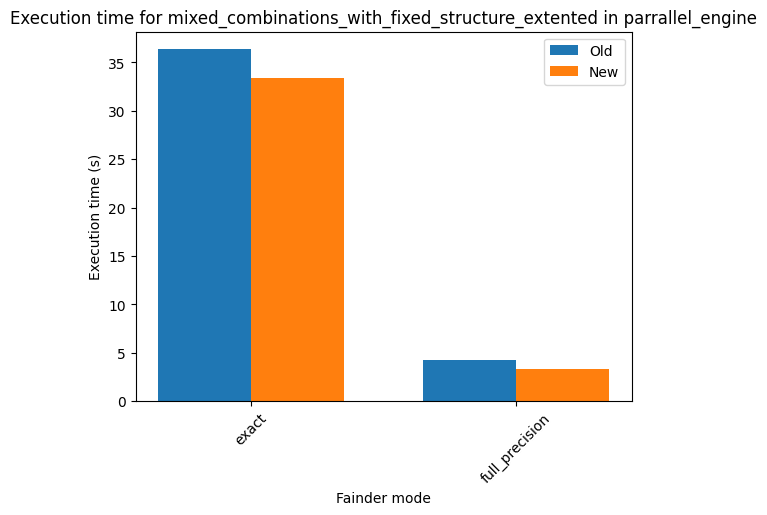

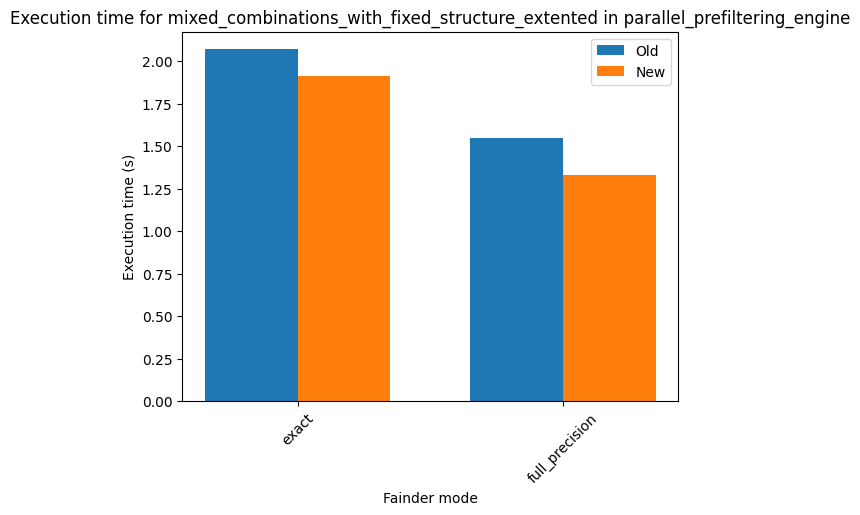

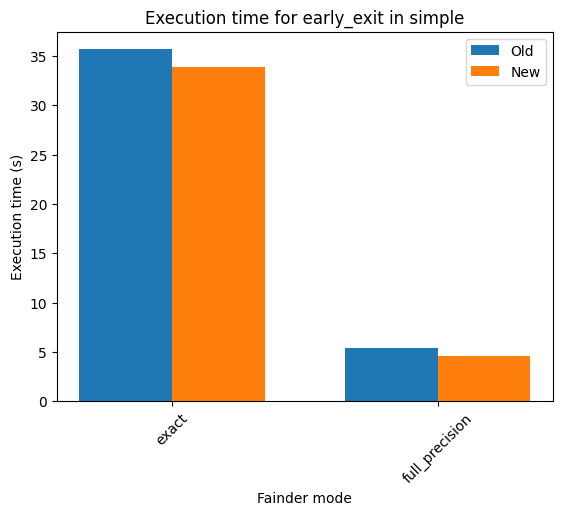

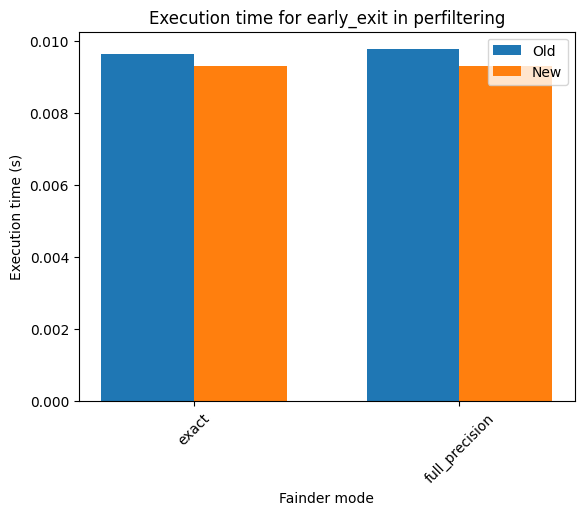

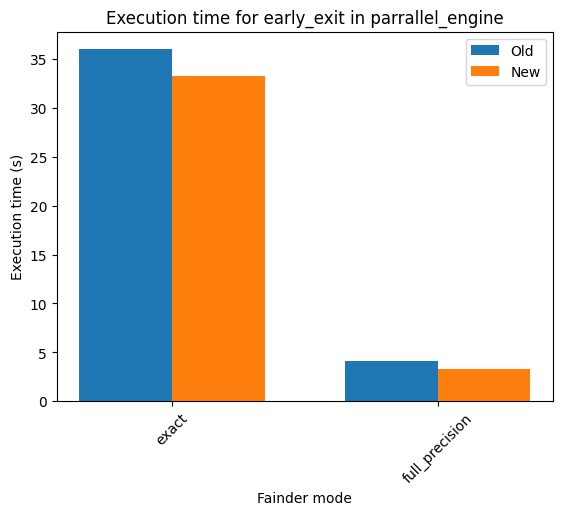

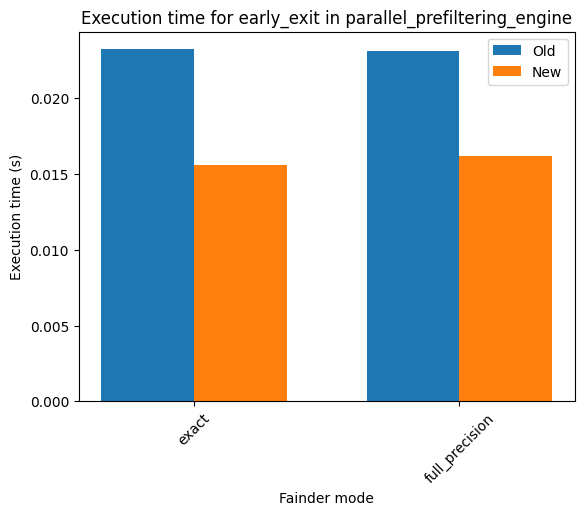

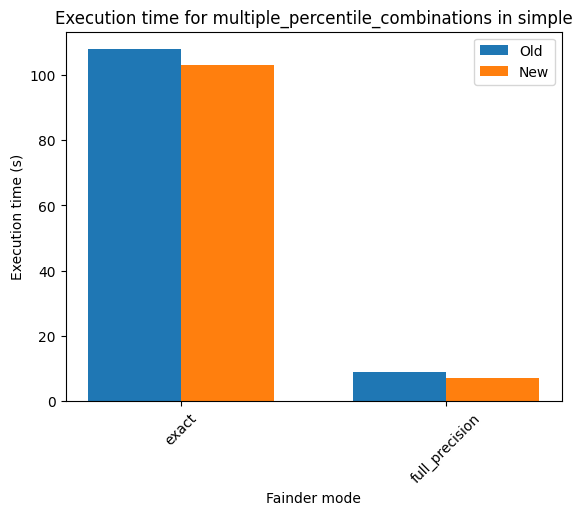

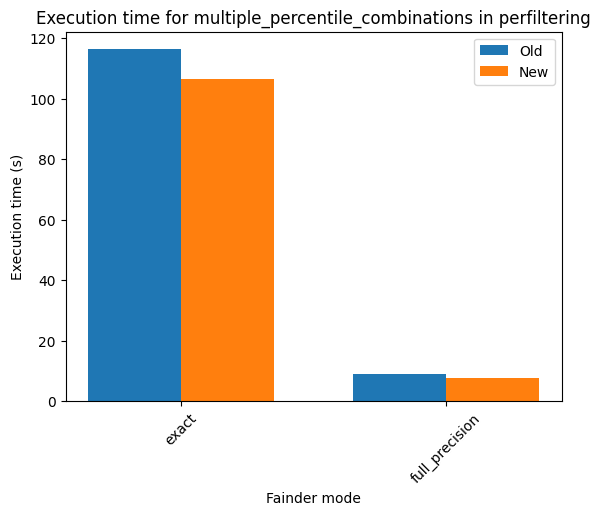

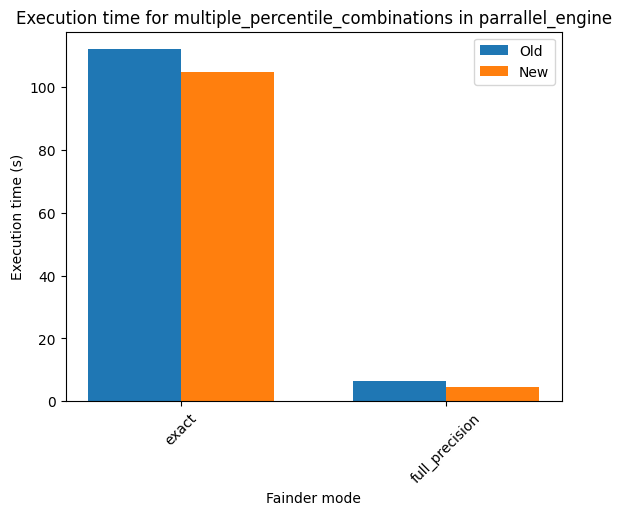

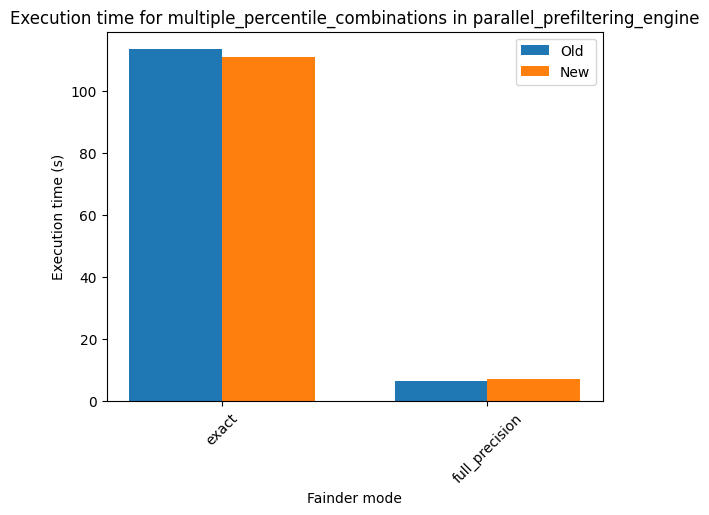

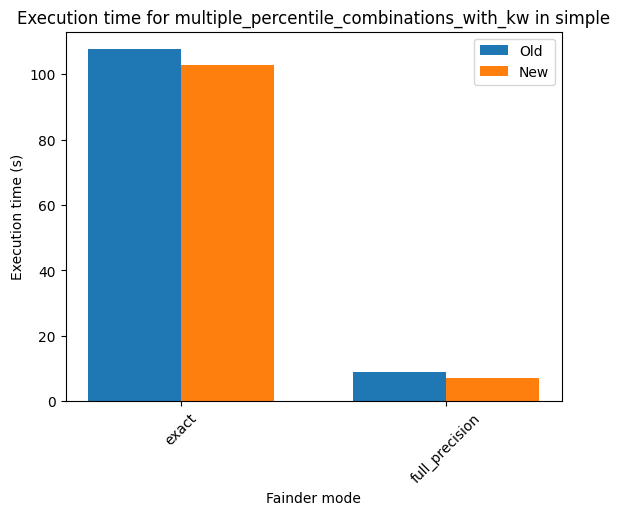

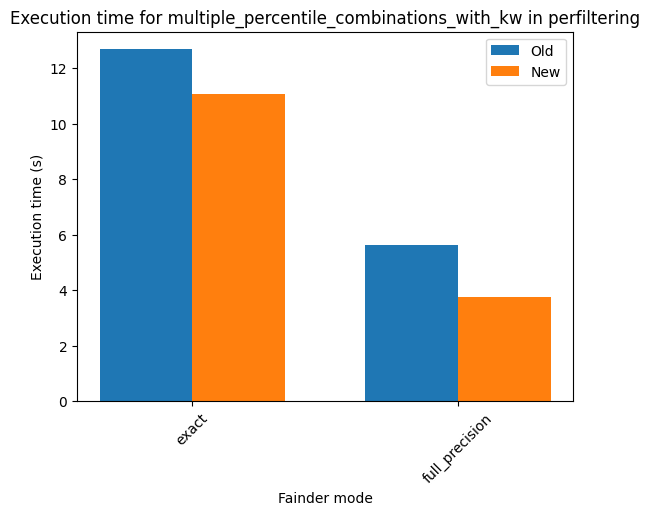

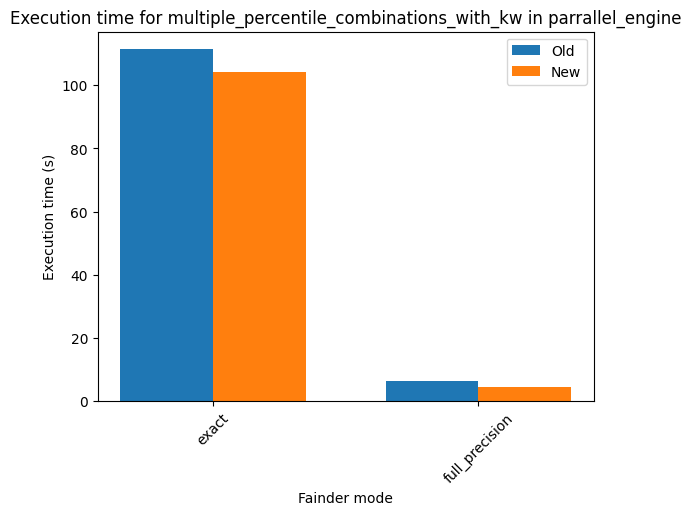

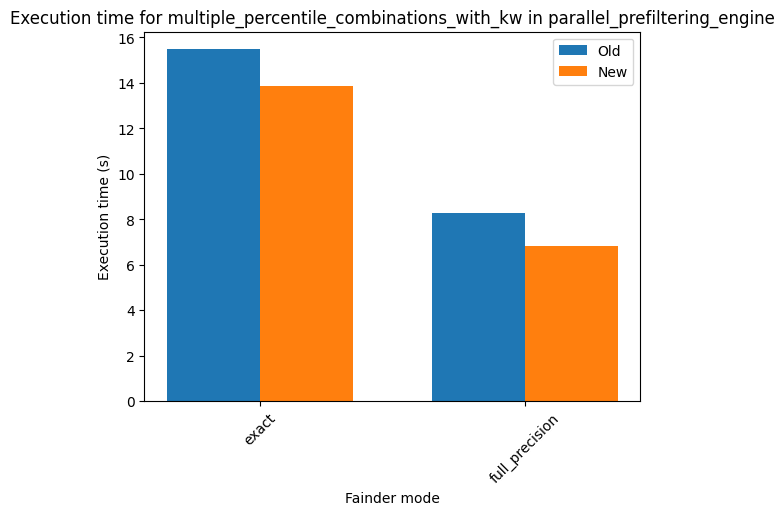

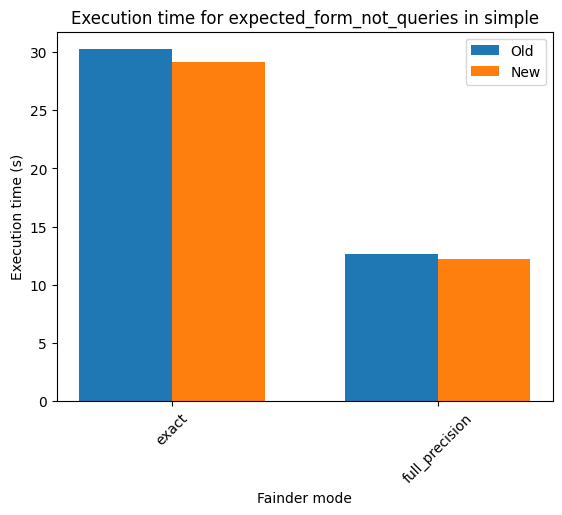

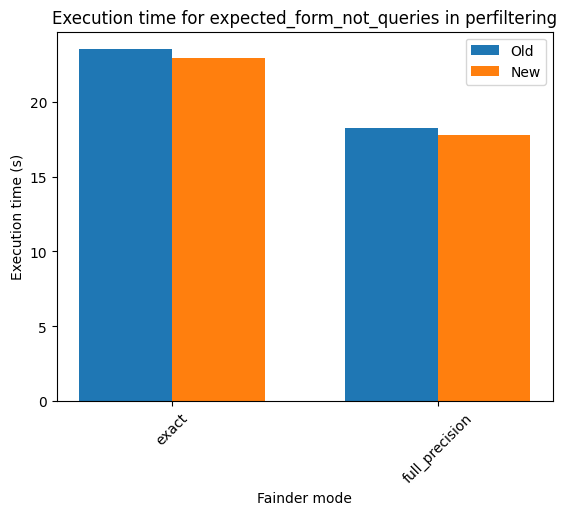

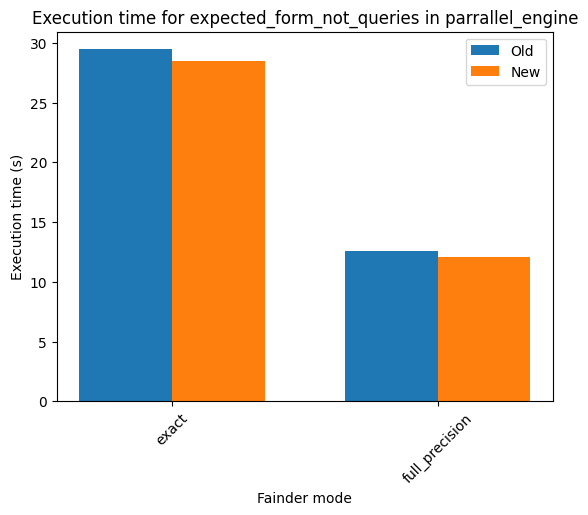

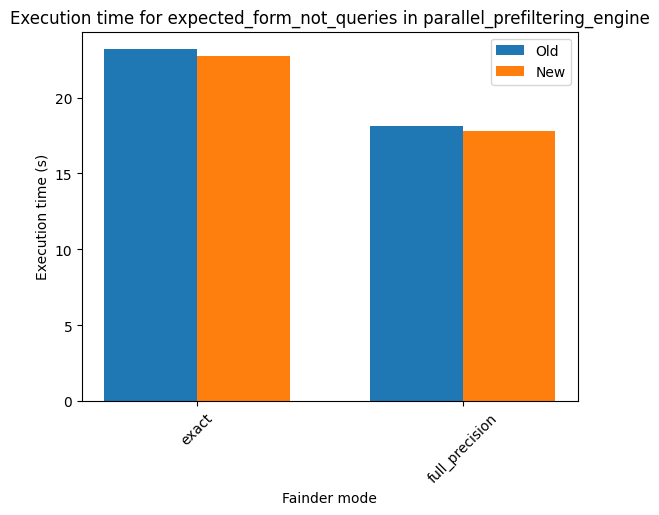

In [15]:
# For each category and fainder_mode (new plot) do a bar plot of the average execution time with scenario on the x-axis
import numpy as np

# Create the directory if it doesn't exist
if not os.path.exists("figures"):
    os.makedirs("figures")
if not os.path.exists("figures/regression"):
    os.makedirs("figures/regression")

scenarios = df_latest_new["scenario"].unique()
categories = df_latest_new["category"].unique()
fainder_modes = df_latest_new["fainder_mode"].unique()

for category in categories:
    for scenario in scenarios:
        df_latest_new_temp = df_latest_new[
            df_latest_new["category"] == category
        ]
        df_latest_new_temp = df_latest_new_temp[
            df_latest_new_temp["scenario"] == scenario
        ]
        df_latest_old_temp = df_latest_old[
            df_latest_old["category"] == category
        ]
        df_latest_old_temp = df_latest_old_temp[
            df_latest_old_temp["scenario"] == scenario
        ]
        
        # Create individual figure
        plt.figure()

        mean_execution_times_new = df_latest_new_temp.groupby("fainder_mode")["execution_time"].mean()
        mean_execution_times_old = df_latest_old_temp.groupby("fainder_mode")["execution_time"].mean()

        x = np.arange(len(mean_execution_times_new.index))
        width = 0.35

        plt.bar(x - width/2, mean_execution_times_old.values, width, label='Old')
        plt.bar(x + width/2, mean_execution_times_new.values, width, label='New')

        plt.title(f"Execution time for {category} in {scenario}")
        plt.xlabel("Fainder mode")
        plt.ylabel("Execution time (s)")
        plt.xticks(x, mean_execution_times_new.index, rotation=45)
        plt.legend()
        
        # Save individual figure
        plt.savefig(f'figures/regression/execution_time_{category}_{scenario}.png', bbox_inches='tight')






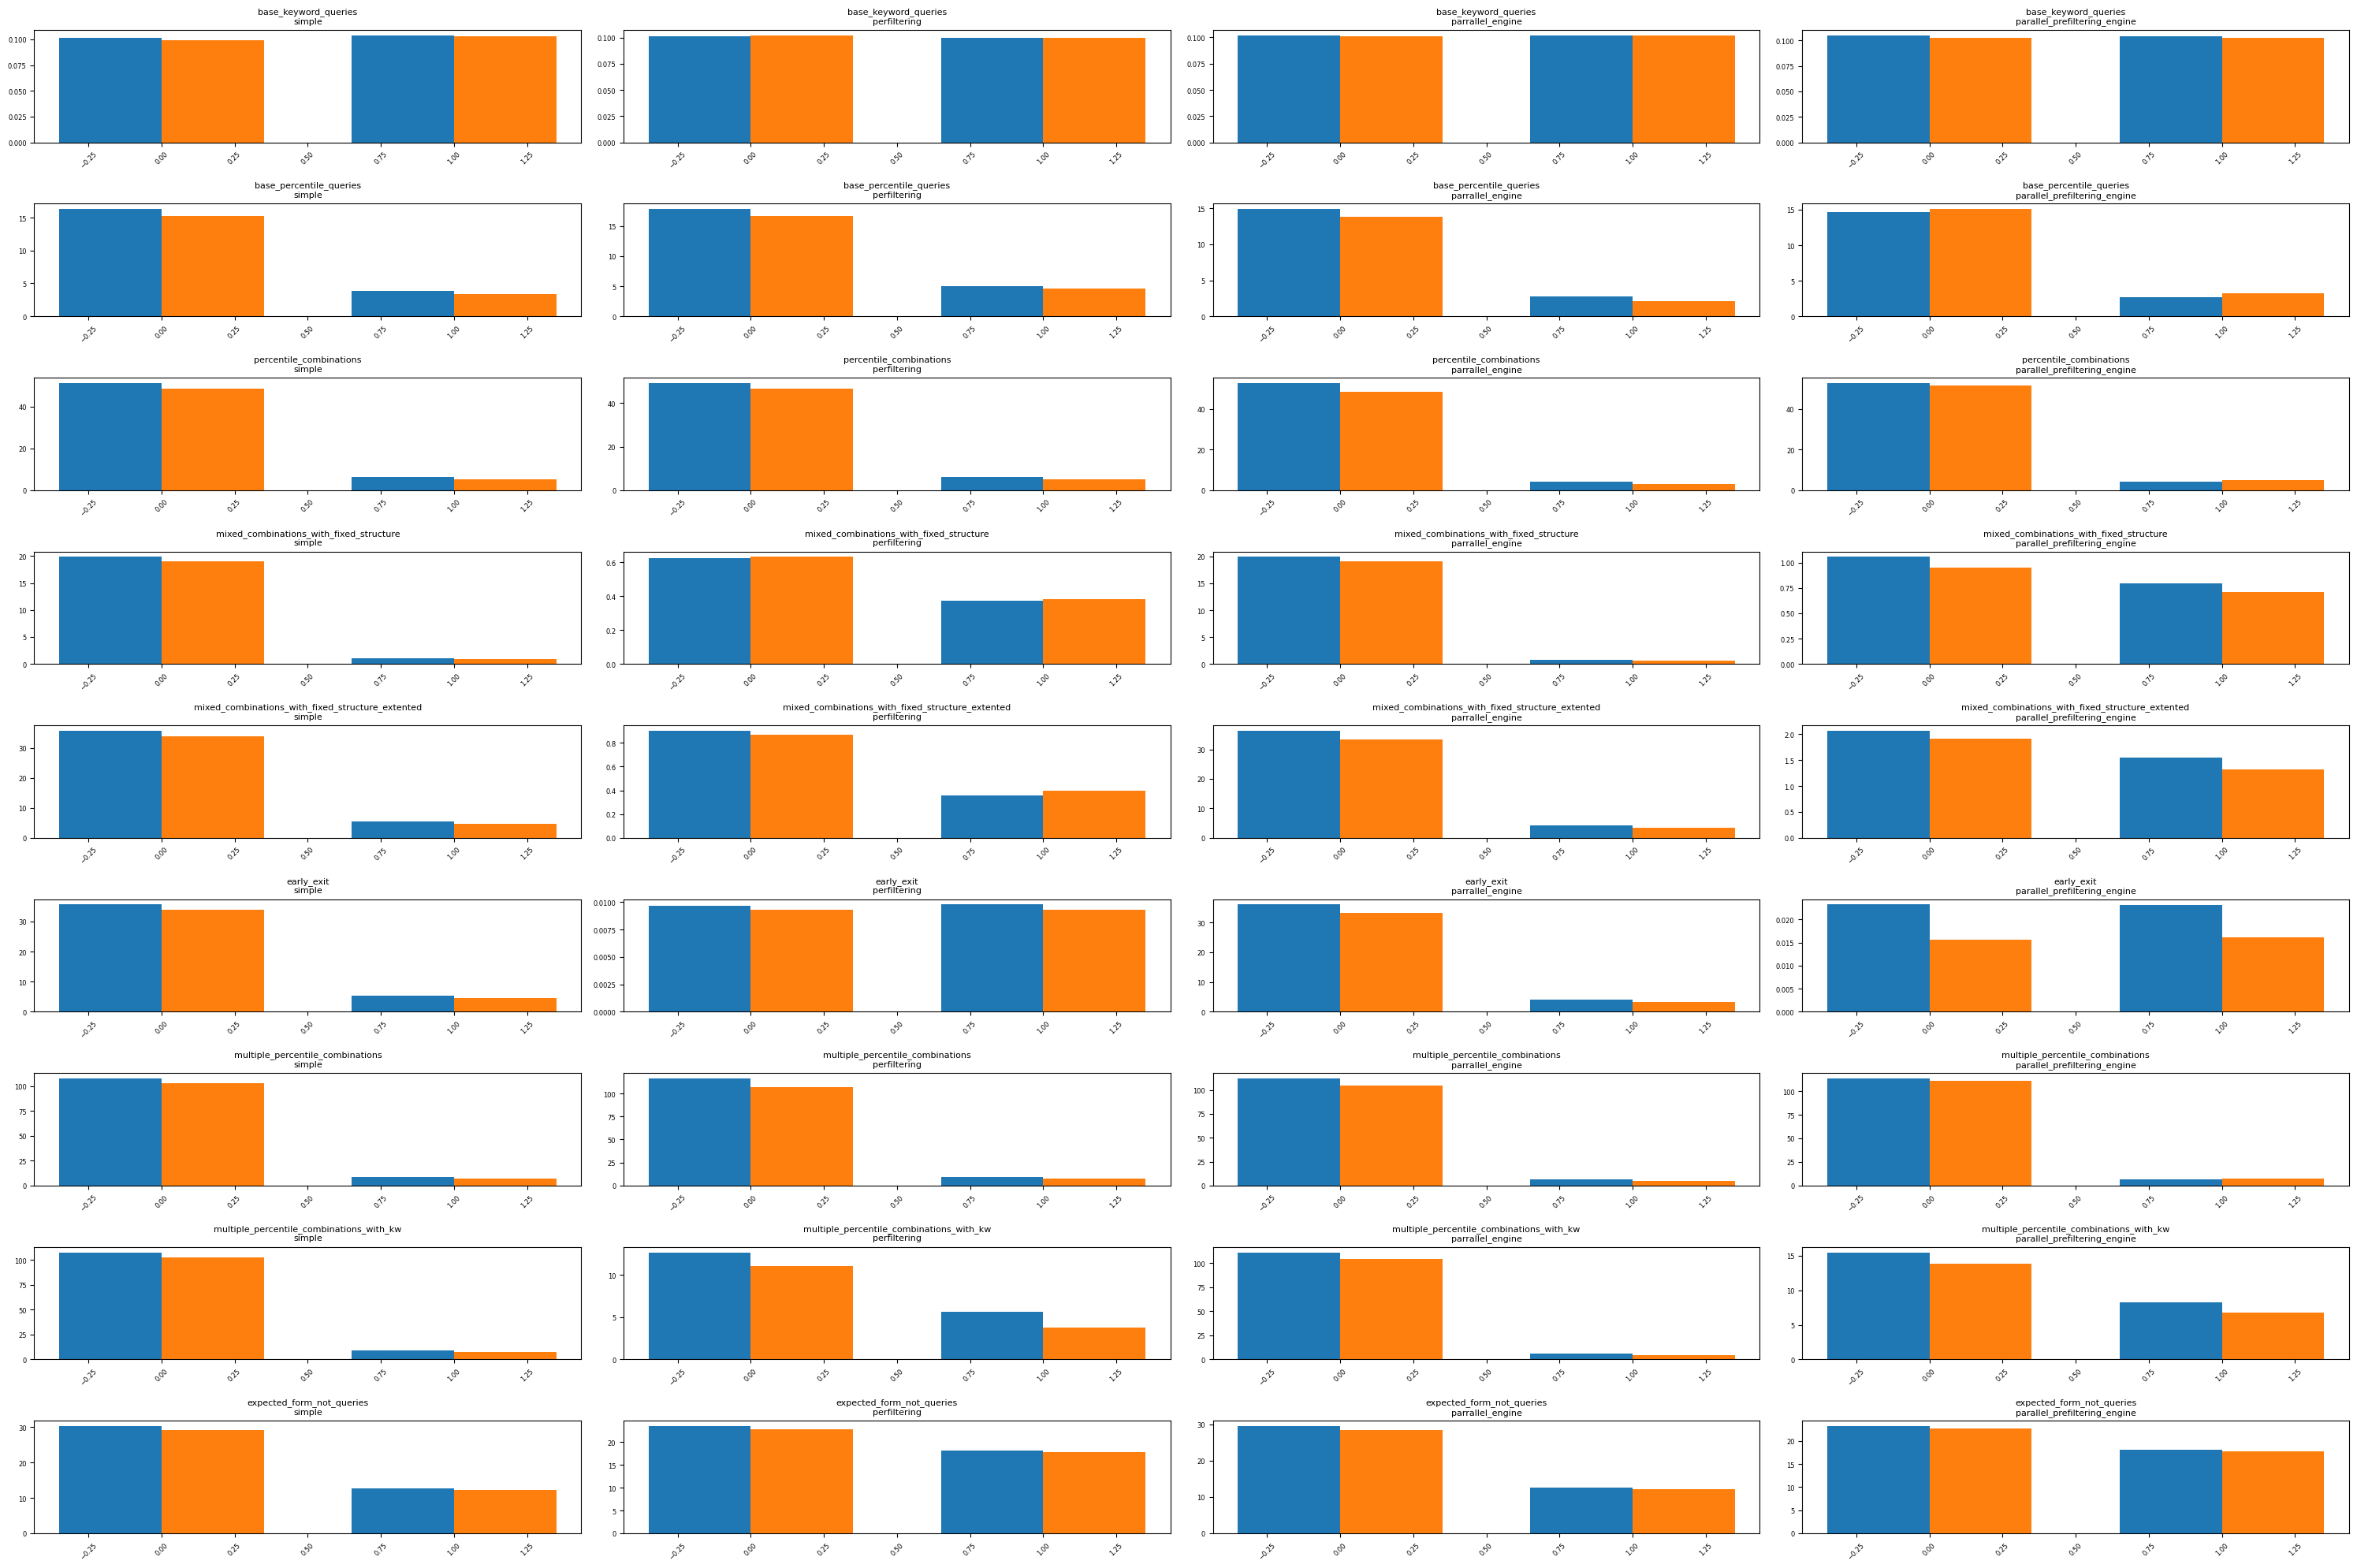

In [16]:
# Create combined figure
plt.figure(figsize=(30, 20))
num_plots = len(categories) * len(scenarios)
rows = (num_plots + 3) // 4  # Ceiling division to determine number of rows
cols = min(4, num_plots)  # Maximum 4 columns

for idx, (category, scenario) in enumerate([(c, s) for c in categories for s in scenarios]):
    plt.subplot(rows, cols, idx + 1)
    
    df_latest_new_temp = df_latest_new[df_latest_new["category"] == category]
    df_latest_new_temp = df_latest_new_temp[df_latest_new_temp["scenario"] == scenario]
    df_latest_old_temp = df_latest_old[df_latest_old["category"] == category]
    df_latest_old_temp = df_latest_old_temp[df_latest_old_temp["scenario"] == scenario]
    
    mean_execution_times_new = df_latest_new_temp.groupby("fainder_mode")["execution_time"].mean()
    mean_execution_times_old = df_latest_old_temp.groupby("fainder_mode")["execution_time"].mean()
    
    x = np.arange(len(mean_execution_times_new.index))
    width = 0.35

    plt.bar(x - width/2, mean_execution_times_old.values, width, label='Old')
    plt.bar(x + width/2, mean_execution_times_new.values, width, label='New')

    
    plt.title(f"{category}\n{scenario}", fontsize=8)
    plt.xticks(rotation=45, fontsize=6)
    plt.yticks(fontsize=6)
    
plt.tight_layout()
plt.savefig('figures/regression/all_execution_times.png')


In [17]:
# For each category and fainder_mode (new plot) do a bar plot for profiling data 
# with function_info on the x-axis

for category in categories:
    for scenario in scenarios:
        df_latest_new_temp = df_latest_new_profiling[
            df_latest_new_profiling["category"] == category
        ]
        df_latest_new_temp = df_latest_new_temp[
            df_latest_new_temp["scenario"] == scenario
        ]
        df_latest_old_temp = df_latest_old_profiling[
            df_latest_old_profiling["category"] == category
        ]
        df_latest_old_temp = df_latest_old_temp[
            df_latest_old_temp["scenario"] == scenario
        ]
        plt.figure()

        mean_execution_times_new = (
            df_latest_new_temp.groupby("function_info")["tottime"].mean()
        )

        mean_execution_times_old = (
            df_latest_old_temp.groupby("function_info")["tottime"].mean()
        )

        print(mean_execution_times_new)

        plt.bar(
            mean_execution_times_new.index,
            mean_execution_times_old.values,
        )

        plt.bar(
            mean_execution_times_new.index,
            mean_execution_times_new.values,
            alpha=0.5,
        )
        plt.title(f"Execution time for {category} in {scenario}")
        plt.xlabel("Function info")
        plt.ylabel("Execution time (s)")

        plt.legend(["Old", "New"])
        plt.xticks(rotation=45)




NameError: name 'df_latest_new_profiling' is not defined